In [1]:
from sklearn.linear_model import LogisticRegression
from IPython.html.widgets import interact
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/Users/choldgraf/anaconda/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# How the decision boundary affects classifier performance

In [2]:
# These will define the shape of the point clouds
a_slope = 2
a_offset = 3
a_noise = 4

b_slope = 6
b_offset = 0
b_noise = 2

Text(0.5,1,'Point clouds for each class')

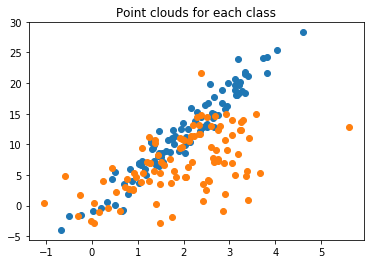

In [3]:
n_points = 100
a_x = np.random.randn(n_points) + 2
a_y = a_slope * a_x + a_offset + np.random.randn(n_points) * a_noise

b_x = np.random.randn(n_points) + 2
b_y = b_slope * b_x + b_offset + np.random.randn(n_points) * b_noise

fig, ax = plt.subplots()
ax.plot(b_x, b_y, 'o')
ax.plot(a_x, a_y, 'o')

ax.set_title('Point clouds for each class')

In [4]:
# Stack these datapoints and fit a classifier on the data
X = np.hstack([[a_x, a_y], [b_x, b_y]]).T
y = np.ones(X.shape[0])
y[n_points:] = 0

model = LogisticRegression()
model.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Now we can visualize the separating hyperplane that this model has discovered in the data.

Text(0.5,1,'Each class and the separating decision boundary')

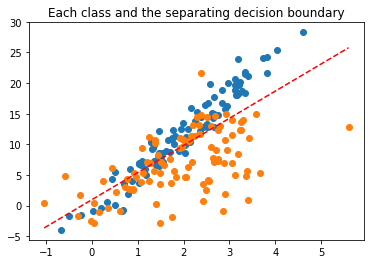

In [5]:
# Plot the line
w = model.coef_[0]
a = -w[0] / float(w[1])
xx = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 100)
yy = a * xx - (model.intercept_[0]) / float(w[1])

fig, ax = plt.subplots()
ax.plot(b_x, b_y, 'o')
ax.plot(a_x, a_y, 'o')
ax.plot(xx, yy, 'r--')

ax.set_title('Each class and the separating decision boundary')

Below we can perform the classification using a number of offset parameters for the decision boundary. This is similar to how ROC curves are constructed. One would compare the true-positives vs. false-positives for each position of the decision boundary, constructing the ROC curve in the process.

<function __main__.plot_distributions>

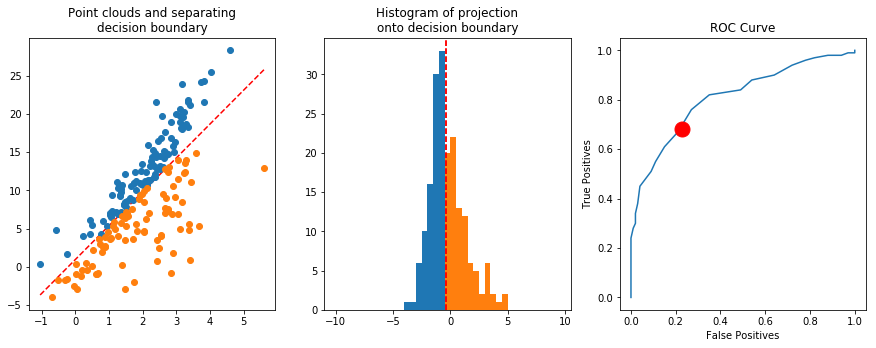

In [6]:
int_min, int_max = -10., 10.

def calculate_true_false_positives(predictions, y, positive_class=1):
    # We'll define `1` as the positive class
    positives = predictions == 1
    if sum(positives) == 0:
        true_ratio = 0
        false_ratio = 0
    else:
        # Sum the number of samples where the classifier...
        # Correctly predicted the class
        true_positives = np.sum(positives[y == 1])
        true_ratio = true_positives / sum(y == 1)
        # Incorrectly predicted the class
        false_positives = np.sum(positives[y != 1])
        false_ratio = false_positives / sum(y != 1)
    return false_ratio, true_ratio
    
def plot_distributions(intercept=model.intercept_[0]):    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot the line for this intercept
    w = model.coef_[0]
    a = -w[0] / float(w[1])
    xx = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 100)
    yy = a * xx - (intercept) / float(w[1])
    axs[0].plot(xx, yy, 'r--')
    
    # Calculate projections
    projection = np.dot(X, w)
    predictions = np.where((projection + intercept) < 0, 0, 1)

    # Plot histograms of each class
    for label in [0, 1]:
        positives = predictions == label
        this_proj = projection[positives]
        this_pts = X[positives]

        # Plot the point clouds and histogram
        axs[0].plot(this_pts[:, 0], this_pts[:, 1], 'o')
        axs[0].set(title='Point clouds and separating\ndecision boundary')
        axs[1].hist(this_proj, bins=np.arange(-10, 10, .5))
        axs[1].axvline(-intercept, color='r', ls='--')
        axs[1].set(title='Histogram of projection\nonto decision boundary')
        # Now highlight the ROC point
        if label == 1:
            false_ratio, true_ratio = calculate_true_false_positives(
            predictions, y)
            axs[2].plot(false_ratio, true_ratio, 'ro', ms=15, zorder=5)
            
    # Create the ROC curve itself
    roc_curve = []
    for i_intercept in np.linspace(int_min, int_max, 100):
        predictions = np.where((projection + i_intercept) < 0, 0, 1)
        
        false_ratio, true_ratio = calculate_true_false_positives(
            predictions, y)
        roc_curve.append((false_ratio, true_ratio))
    roc_curve = np.array(roc_curve).T
    
    # Now plot the ROC curve
    axs[2].plot(*roc_curve)
    axs[2].set(xlim=[-.05, 1.05], ylim=[-.05, 1.05])
    axs[2].set(ylabel='True Positives', xlabel='False Positives',
               title='ROC Curve')
interact(plot_distributions, intercept=[int_min, int_max, .1],)